In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql.functions import col, explode, trim, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, NGram
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/15 12:35:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.option('escape','"').csv('ks-projects-201801.csv', header=True, inferSchema=True, mode="DROPMALFORMED")
df=df.na.drop("any")

df=df.filter((col("state") == "failed") | (col("state") == "successful"))

### Preparing datasets for ngrams

In [4]:
#remove special character from titles
df = df.withColumn("name", regexp_replace("name","[.?,&:!-]",""))
#remove extra space from title
df = df.withColumn("name", regexp_replace("name"," +"," "))

In [5]:
tokenizer = Tokenizer(inputCol="name", outputCol="words")
# Remove stop words from titles (the, and, in...)
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
#tokenize and remove stopwords
df = remover.transform(tokenizer.transform(df))
df=df.drop("name", "words")

In [6]:
#add the ngram column to the dataset, in this case n=2 so bigrams
#the column contains a list with every bigram extracted from the title. Remove the filtered_words columns, we do not need it
ngram_df = NGram(n=2, inputCol="filtered_words", outputCol="bigrams").transform(df).drop("filtered_words")

#explode the bigram column so for each bigram of a row, there will be created a new row with one bigram
#after that group and count the bigrams for obtaining the overhaul count
result=ngram_df.select(explode("bigrams").alias("bigram")).groupBy("bigram").count().sort("count", ascending=False)

In [7]:
n=10  #top n bigrams used

#transform the dataset in pandas and than into a dictionary with bigrams as key for the plot , only n values are transformed into a pandas dataframe 
bigram_counts = result.limit(n).toPandas().set_index('bigram').to_dict()["count"]

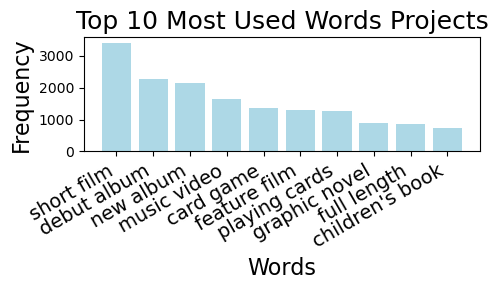

In [8]:
#plot the top n bigrams count
fig, axes = plt.subplots(figsize=(5, 3))

axes.bar(bigram_counts.keys(),bigram_counts.values(), color='lightblue')
axes.set_title(f'Top {n} Most Used Words Projects', fontsize=18)
axes.set_xlabel('Words', fontsize=16)
axes.set_ylabel('Frequency', fontsize=16)
axes.tick_params(axis='x', labelsize=14)
plt.setp(axes.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()

In [9]:
#extract top 10 bigrams for succesfull and failed project and transform into dictionaries
#only the top 10 bigrams are transformed into a dictionary
n=10  #top n bigrams used

successful_bigram=ngram_df.filter(col("state") == "successful")\
    .select(explode("bigrams")\
    .alias("bigram"))\
    .groupBy("bigram")\
    .count().sort("count", ascending=False)\
    .limit(n)\
    .toPandas().set_index('bigram').to_dict()["count"]

failed_bigram=ngram_df.filter(col("state") == "failed")\
    .select(explode("bigrams")\
    .alias("bigram"))\
    .groupBy("bigram")\
    .count().sort("count", ascending=False)\
    .limit(n)\
    .toPandas().set_index('bigram').to_dict()["count"]


In [11]:
#calculate the success / fail percentage of top n bigrams. the percentage is defined as succ_perc = succ_count/total_count
for bigram in bigram_counts.keys():
    succ_count = successful_bigram.get(bigram)
    fail_count = failed_bigram.get(bigram)
    if((succ_count != None) and (fail_count != None)):
        total_count = bigram_counts.get(bigram)
        succ_perc = succ_count / total_count
        fail_perc = fail_count / total_count
        print("%s \tsucc: %.1f \t fail %.1f"%(bigram,succ_perc*100,fail_perc*100))

short film 	succ: 65.1 	 fail 34.9
debut album 	succ: 65.4 	 fail 34.6
new album 	succ: 70.8 	 fail 29.2
music video 	succ: 49.3 	 fail 50.7
card game 	succ: 51.1 	 fail 48.9
feature film 	succ: 42.7 	 fail 57.3
playing cards 	succ: 65.8 	 fail 34.2
graphic novel 	succ: 53.9 	 fail 46.1


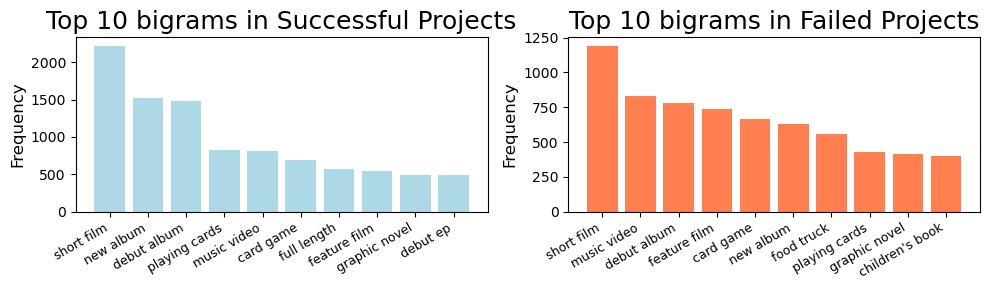

In [12]:
#plot the success and fail count of the top 10 fail/successful bigrams
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

#Successful
axes[0].bar(successful_bigram.keys(), successful_bigram.values(), color='lightblue')
axes[0].set_title(f'Top {n} bigrams in Successful Projects', fontsize=18)
#axes[0].set_xlabel('Words', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].tick_params(axis='x', labelsize=9)

#Failed
axes[1].bar(failed_bigram.keys(), failed_bigram.values(), color='coral')
axes[1].set_title(f'Top {n} bigrams in Failed Projects', fontsize=18)
#axes[1].set_xlabel('Words', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].tick_params(axis='x', labelsize=9)


plt.setp(axes[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axes[1].get_xticklabels(), rotation=30, horizontalalignment='right')

plt.tight_layout()
plt.show()